# Setup
including loading packages, defining helper plotting functions, and generating subfigures

NOTE: necessary to run if you are running anything else in this notebook

In [22]:
%load_ext autoreload
%autoreload 2

import argparse
import sys
import os

import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image, ImageDraw, ImageFont

from src import secondlevel_group_glm
from src import secondlevel_group_encoding
from src import secondlevel_individual_encoding
from src import helpers
from src import plotting_helpers

load = True #set load=True to load analysis files (need to have downloaded them beforehand). False will run all analyses before plotting them (will take longer)
generate_subfigures = True # will take much longer than downloading the subfigures to use in making the main figures
base_dir = '../' #automatically uses this project directory, can be set to a different location

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def get_default_args(base_dir):
	args_dict = { 
				'model': None,
				'task':	'sherlock',
				'mask':	'ISC',
				'perc_top_voxels':	5,
				'space': 'MNI152NLin2009cAsym',
				'smoothing_fwhm': 3.0,
				'chunklen': 20,
				'population': 'NT',
				'feature_of_interest': None,
				'ISC_type':'leave_one_out',
				'dir': base_dir,
				'out_dir': os.path.join(base_dir,'analysis'),
				'figure_dir': os.path.join(base_dir,'figures','subfigures')
			}
	return args_dict
def construct_args(args_dict):
	parser = argparse.ArgumentParser()
	parser.add_argument('--model','-model',type=str,default=args_dict['model'])
	parser.add_argument('--task','-task',type=str,default=args_dict['task'])
	parser.add_argument('--mask','-mask',type=str, default=args_dict['mask']) #the mask that contains all masks of interest (overarching mask )
	parser.add_argument('--perc-top-voxels','-perc-top-voxels',type=int,default=args_dict['perc_top_voxels'])
	parser.add_argument('--space','-space',type=str,default=args_dict['space'])
	parser.add_argument('--smoothing-fwhm','-smoothing-fwhm',type=float,default=args_dict['smoothing_fwhm'])
	parser.add_argument('--chunklen','-chunklen',type=int,default=args_dict['chunklen'])
	parser.add_argument('--population','-population',type=str,default=args_dict['population'])
	parser.add_argument('--feature-of-interest','-feature-of-interest',type=str,default=args_dict['feature_of_interest'])
	parser.add_argument('--ISC-type','-ISC-type',type=str,default=args_dict['ISC_type'])

	parser.add_argument('--dir', '-dir', type=str,
						default=args_dict['dir'])
	parser.add_argument('--out_dir', '-output', type=str,
						default=args_dict['out_dir'])
	parser.add_argument('--figure_dir', '-figures', type=str,
						default=args_dict['figure_dir'])
	def filter_jupyter_args(args):
		# Filter out any args starting with --f= (Jupyter passes --f=<file>)
		return [arg for arg in args if not arg.startswith('--f=')]
	filtered_args = filter_jupyter_args(sys.argv)
	args = parser.parse_args(filtered_args[1:])  # [1:] to skip the script name
	return args

def plot_secondlevel_group_glm(base_dir,task,cmap='gray_inferno'):
	args_dict = get_default_args(base_dir)
	args_dict['task']=task
	args_dict['mask']=None
	args = construct_args(args_dict)

	### GROUP ANALYSIS
	secondlevel_group = secondlevel_group_glm.SecondLevelGroup(args)
	secondlevel_group.do_stats = False

	secondlevel_group.compile_data()
	secondlevel_group.plot_zscores(vmin=0,FDR_correction=True, threshold=0.01,symmetric_cbar=False,cmap=cmap) #
def plot_secondlevel_group_encoding(base_dir,model,plotting,feature_names,cmap='gray_inferno',diff_cmap='',mask='ISC',load=False,vmax=None):
	args_dict = get_default_args(base_dir)
	args_dict['model']=model
	args_dict['mask'] = mask
	args_dict['mask_name'] = mask
	if(model=='correlation'):
		args_dict['smoothing_fwhm'] = 6.0

	args = construct_args(args_dict)

	### GROUP ANALYSIS
	secondlevel_group = secondlevel_group_encoding.SecondLevelGroup(args)
	secondlevel_group.do_stats = False
	secondlevel_group.explainable_variance_mask = False
	secondlevel_group.feature_names = feature_names
	secondlevel_group.scale_by=''#'total_variance'
	if(not load):
		secondlevel_group.compile_data(measures=['performance']+plotting) #always need to do performance to get proper brain shape and affine
	if('preference_map' in plotting):
		secondlevel_group.compute_preference_maps(restricted=False)
	secondlevel_group.save_results()
	if('performance' in plotting):
		title = ''
		if(model=='correlation'):
			secondlevel_group.permutation_brainiak(load=load)
			title='Intersubject Correlation'
		else:
			secondlevel_group.stats_wilcoxon()
			title = 'Joint Encoding Model Performance'
		secondlevel_group.plot_performance('stats',threshold=0.00001,vmin=0,vmax=vmax,cmap=cmap,title=title)
	if('ind_product_measure' in plotting):
		secondlevel_group.stats_wilcoxon()
		secondlevel_group.plot_ind_product_measure('stats',threshold=0.00001,vmin=0,vmax=vmax,cmap=cmap)
	if('added_variance' in plotting):
		secondlevel_group.plot_added_variance('raw',threshold=0.00001,vmin=0,vmax=vmax,cmap=cmap)
	if('unique_variance' in plotting):
		secondlevel_group.plot_unique_variance('raw',threshold=0.00001,vmin=0,vmax=vmax,cmap=cmap)
	if('spatial_correlation' in plotting):
		secondlevel_group.plot_spatial_correlation('raw',threshold=None,vmin=None,vmax=vmax,cmap=cmap)
	if('ind_feature_performance' in plotting):
		secondlevel_group.plot_ind_feature_performance('raw',threshold=0.01,vmin=0,vmax=vmax,cmap=cmap)
	if('preference_map' in plotting):
		secondlevel_group.plot_preference_maps(label='both')
	if('difference' in plotting):
		secondlevel_group.plot_difference('raw',threshold=0.01,cmap=diff_cmap,vmax=vmax)
def get_secondlevel_individual(base_dir, model):
	args_dict = get_default_args(base_dir)
	args_dict['model']=model
	args = construct_args(args_dict)

	secondlevel_ind = secondlevel_individual_encoding.SecondLevelIndividual(args)
	secondlevel_ind.localizer_contrasts = {'SIpointlights':{'interact&no_interact','interact-no_interact'},'social interaction':{'interact&no_interact','interact-no_interact'},'language':{'intact-degraded'}}
	
	## specifying the names of each mask
	MT = ['MT']
	ISC = ['ISC']
	STS = ['pSTS','aSTS']#'frontal_language']
	language =['pTemp','aTemp','frontal']
	language_ROI_names = ['pTemp','aTemp','frontal']
	secondlevel_ind.localizer_masks = {'interact&no_interact':MT,'interact-no_interact':STS,'intact-degraded':language, 'degraded-intact':STS,
							'motion pointlights':MT,'SI pointlights':STS, 'language':language, 'DMN':STS,
							'social interaction':STS,'social':STS,
       						'GPT2':STS,'sbert':language,'sbert+word2vec':language,'word2vec':language,'hubert':language,
							'motion':MT,'num_agents':STS, 'alexnet':STS,'alexnet':STS,
							'valence':STS,'face':STS,'mentalization':STS, 'arousal':STS,
							'speaking':STS,'indoor_outdoor':STS,
							'turn_taking':STS,'written_text':STS,'music':STS,'none':STS}
	secondlevel_ind.MT = MT
	secondlevel_ind.ISC = ISC
	secondlevel_ind.STS = STS
	secondlevel_ind.language = language
	secondlevel_ind.language_ROI_names = language_ROI_names
	return secondlevel_ind

In [9]:
#load the default arguments for easy access
args_dict = get_default_args(base_dir)
subject = 'sub-33' #specifying representative subject #sub-26, sub-39 are other options

In [11]:
def label_brain_plots(output_filename, final_image, labels_dict={}, desc_dict={}, feature_names=[], features_on_width=True,pad_prop=0,include_desc=True,include_ind_group_labels=True,color_dict=None):
    # add padding for the labels
    pad = 200
    if features_on_width:
        padding = (pad, pad, pad, pad)
    else:
        padding = (pad, pad, pad, 0)
    
    new_width = final_image.width + padding[0] + padding[2]
    new_height = final_image.height + padding[1] + padding[3]

    new_image = Image.new('RGBA', (new_width, new_height), (255, 255, 255, 0))
    new_image.paste(final_image, (padding[0], padding[1]))

    draw = ImageDraw.Draw(new_image)
    font = ImageFont.truetype("Arial Bold.ttf", 85)
    label_font = ImageFont.truetype("Arial Bold.ttf", 125)  # Larger font for 'Individual' and 'Group'
    width, height = final_image.size
    
    if features_on_width:
        portion = width // len(feature_names)
        centers = [(portion * i + portion // 2.35, 15) for i in range(len(feature_names))]
    else:
        portion = height // len(feature_names)
        centers = [(new_width // 2, (portion * i)-pad_prop*portion/3) for i in range(len(feature_names))]
    
    text_padding = 25
    if(len(feature_names)>1):
        for center, feature in zip(centers, feature_names):
            bbox = draw.textbbox((0, 0), labels_dict[feature], font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]
            
            if features_on_width:
                text_x = center[0] - (text_width // 2) + pad
                text_y = center[1] + (text_height // 2)
                rectangle_x = center[0] - portion // len(feature_names)
                rectangle_coords = (
                    rectangle_x + pad,                # Left
                    text_y - text_padding,                     # Top
                    rectangle_x + (portion//len(feature_names)*2) +pad ,        # Right
                    text_y + text_padding*5      # Bottom
                    )
            else:
                text_x = center[0] - (text_width // 2)
                text_y = center[1] - (text_height // 2) + pad
                rectangle_x = center[0] - (text_width //2)
                rectangle_coords = (
                    rectangle_x - pad,                # Left
                    text_y - text_padding,                     # Top
                    rectangle_x + text_width+pad ,        # Right
                    text_y + text_padding*5      # Bottom
                    )
            
            draw.rounded_rectangle(rectangle_coords, radius=30, width=10,fill='lightgray')
            draw.text((text_x,text_y), labels_dict[feature], fill="black", font=font)
            
            if(include_desc):
                bbox = draw.textbbox((0, 0), desc_dict[feature], font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                
                if features_on_width:
                    text_x = center[0] - (text_width // 2) + pad
                    text_y = new_image.size[1] - text_height * 1.6
                else:
                    text_x = center[0] - text_width // 2
                    text_y = center[1]  + portion
                
                draw.text((text_x, text_y), desc_dict[feature], fill="black", font=font)
            
    
    if(include_ind_group_labels):
        if features_on_width:
            #rotated labels for labeling Individual and Group brain maps
            for y,text in zip((1,3),['Individual','Group']):
                bbox = draw.textbbox((0, 0), text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
                text_image = Image.new('RGBA', (text_width,text_height+20), (255, 255, 255, 0)) #transparent background
                draw = ImageDraw.Draw(text_image)
                text_position = (0,0)
                draw.text(text_position, text, font=font, fill="black")
                text_image = text_image.rotate(90, resample=Image.BICUBIC, expand=1)
                new_image.paste(text_image, (-15, (final_image.size[1]//4)*y), text_image)
        else:
        # Labels for 'Individual' and 'Group' along the top
            label_positions = [(0.24, 'Individual'), (0.7, 'Group')]
            for pos, text in label_positions:
                bbox = draw.textbbox((0, 0), text, font=label_font)
                text_width = bbox[2] - bbox[0]
                text_x = int(new_image.size[0] * pos - text_width / 2)
                text_y = new_height - (pad)
                draw.text((text_x, text_y), text, font=label_font, fill="black")

    new_image.save(output_filename)
    return new_image

# Running second level analysis and generating subfigures 
NOTE: if you cloned the repository this is not necessary since the subfigures already exist, but it is possible to re-run all second level analyses here if you download extra data from OSF. See below for the requirements.

The minimum data needed to run everything from scratch (setting ```load=False``` and ``` generate_subfigures=True``` ) is the full analysis directory, including the ```EncodingModel```, ```GLM```, ```Brain2Brain```, ```SecondLevelIndividual```, and ```SecondLevelGroup```  directories, which are available on OSF. Running all of the analyses will take some time.

The minimum data needed to create subfigures from precomputed analyses (setting ```load=True``` and ```generate_subfigures=True```) is the ```SecondLevelIndividual```, and ```SecondLevelGroup``` directories from OSF.

The easiest way to run anything is to replace the entire ``` analysis ``` directory in this repository with the downloaded version from OSF. 

### Group maps of ISC and joint encoding model performance and feature performance within joint model

In [29]:
load = False #load is set in Setup! you can change it here though
vmax = 0.13
if generate_subfigures:
    plot_secondlevel_group_encoding(base_dir,'correlation',plotting=['performance'],mask='',feature_names=[],load=load,cmap='gray_inferno_symmetric',vmax=vmax) 
    plot_secondlevel_group_encoding(base_dir,'joint',plotting=['performance'],feature_names=[],cmap='gray_inferno_symmetric',vmax=vmax)
    
    #indvidual feature predictivity group maps
    model = 'joint'
    feature_names = ['alexnet','sbert']
    plotting = ['performance', 'ind_product_measure']
    plot_secondlevel_group_encoding(base_dir,model,plotting,feature_names,load=load,cmap='gray_inferno_symmetric',vmax=vmax) #saves in subfigures folder


0
starting permutation testing
2025-09-08 17:58:20.690545
ended permutation testing
2025-09-08 18:12:03.008804
0
performing signed permutation test...
0
ind_product_measure
(2, 88767)
saved: ind_product_measure
(2, 97, 115, 97)
performing signed permutation test...
performing signed permutation test...


In [10]:
load = False
model = 'joint'
feature_names = ['alexnet','motion','hubert','word2vec','sbert'] 
measure = 'ind_product_measure'
if generate_subfigures:
    # Plot one representative subject's maps of the individual feature product measures from the joint model
    secondlevel_ind = get_secondlevel_individual(base_dir,model) #initialize a secondlevel individual object
    #just one subject
    secondlevel_ind.subjects['SIpointlights'] = [subject]
    for feature in feature_names:
        secondlevel_ind.plot_map(feature=feature,measure=measure,threshold=0.01,vmin=0,vmax=None,cmap='gray_inferno_symmetric')
    # Plot individual features product measure group maps before compiling into one plot
    plotting = ['performance',measure]
    plot_secondlevel_group_encoding(base_dir,model,plotting,feature_names,load=load,cmap='gray_inferno_symmetric',vmax=None) #saves in subfigures folder

100%|██████████| 1/1 [00:55<00:00, 55.52s/it]


0
ind_product_measure
(5, 88767)
saved: ind_product_measure
(5, 97, 115, 97)
performing signed permutation test...
performing signed permutation test...


### Generate brain maps of controlled stimuli tasks

In [11]:
tasks = ['SIpointlights','language'] #SIpointlights contains both the motion contrast and social interaction contrast
if generate_subfigures:
    secondlevel_ind = get_secondlevel_individual(base_dir,'joint') #initialize a secondlevel individual object
    secondlevel_ind.localizer_contrasts['SIpointlights'] = ['interact&no_interact','interact-no_interact']
    secondlevel_ind.localizer_contrasts['language'] = ['intact-degraded']
    for task in tasks:
        secondlevel_ind.subjects[task] = [subject] #plot just one representative subject for each task
        secondlevel_ind.plot_localizer(task=task,symmetric_cbar=False,vmin=0,cmap='gray_inferno_symmetric') 
        plot_secondlevel_group_glm(base_dir,task,cmap='gray_inferno_symmetric') #plot group map for each task

interact-no_interact: sub-33: 100%|██████████| 1/1 [00:55<00:00, 55.98s/it]


{'SIpointlights': ['sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-14', 'sub-15', 'sub-16', 'sub-19', 'sub-23', 'sub-25', 'sub-26', 'sub-28', 'sub-32', 'sub-33', 'sub-35', 'sub-36', 'sub-38', 'sub-39', 'sub-41', 'sub-45', 'sub-46', 'sub-50', 'sub-51', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-60', 'sub-61', 'sub-62'], 'language': ['sub-19', 'sub-23', 'sub-25', 'sub-26', 'sub-28', 'sub-32', 'sub-33', 'sub-35', 'sub-36', 'sub-38', 'sub-39', 'sub-41', 'sub-45', 'sub-46', 'sub-50', 'sub-51', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-60', 'sub-61', 'sub-62'], 'sherlock': ['sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-14', 'sub-15', 'sub-16', 'sub-19', 'sub-23', 'sub-25', 'sub-26', 'sub-28', 'sub-32', 'sub-33', 'sub-35', 'sub-36', 'sub-38', 'sub-39', 'sub-41', 'sub-45', 'sub-46', 'sub-50', 'sub-51', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-60', 'sub-61', 'sub-62']}
interact
no_interact
i

intact-degraded: sub-33: 100%|██████████| 1/1 [01:03<00:00, 63.40s/it]


{'SIpointlights': ['sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-14', 'sub-15', 'sub-16', 'sub-19', 'sub-23', 'sub-25', 'sub-26', 'sub-28', 'sub-32', 'sub-33', 'sub-35', 'sub-36', 'sub-38', 'sub-39', 'sub-41', 'sub-45', 'sub-46', 'sub-50', 'sub-51', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-60', 'sub-61', 'sub-62'], 'language': ['sub-19', 'sub-23', 'sub-25', 'sub-26', 'sub-28', 'sub-32', 'sub-33', 'sub-35', 'sub-36', 'sub-38', 'sub-39', 'sub-41', 'sub-45', 'sub-46', 'sub-50', 'sub-51', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-60', 'sub-61', 'sub-62'], 'sherlock': ['sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-14', 'sub-15', 'sub-16', 'sub-19', 'sub-23', 'sub-25', 'sub-26', 'sub-28', 'sub-32', 'sub-33', 'sub-35', 'sub-36', 'sub-38', 'sub-39', 'sub-41', 'sub-45', 'sub-46', 'sub-50', 'sub-51', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-60', 'sub-61', 'sub-62']}
intact
degraded
intact

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 5.85168048845247. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:421: RuntimeWarning: invalid value encountered in divide
  data_copy /= (vmax - vmin)
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/plotting_helpers.py:455: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  cbar.ax.set_ylim(vmin, vmax)


### Overlap between social interaction and language ROIs (reported in text, no figure)

In [12]:
def get_overlap(base_dir,masks,perc_top_voxels,load=False,file_tag=''):
    """This function sets up all required analyses for the overlap between social interaction and language regions to be computed. 
        It runs the glm voxel selection for social interaction and language both within the STS parcel, for the most conservative 
        estimate of overlap. 
        If there are multiple masks, the voxel selection happens within in each and then the overlap is computed on their union. """
    secondlevel = get_secondlevel_individual(base_dir,'joint')
    secondlevel.perc_top_voxels=str(perc_top_voxels)
    
    enc_localizer_label_dict = {}
    glm_localizer_label_dict = {}
    file_tag = file_tag
    regions = []
    secondlevel = get_secondlevel_individual(base_dir, 'joint')
    secondlevel.perc_top_voxels=str(perc_top_voxels)
    #runs glm and encoding voxel selection again with the same mask across both domains
    glm_localizers_to_plot = ['social interaction', 'language']

    all_localizers = glm_localizers_to_plot
    for localizer in all_localizers:
        secondlevel.localizer_masks[localizer]=masks
        glm_localizer_label_dict[localizer] = 'STS' #making all localizers in the STS
    secondlevel.localizer_masks['interact-no_interact']=masks
    secondlevel.localizer_masks['intact-degraded']=masks

    secondlevel.localizer_contrasts = {'SIpointlights':{'interact-no_interact'},'social interaction':{'interact-no_interact'},'language':{'intact-degraded'}}
    secondlevel.language = masks #putting all localizers (social and language) in STS for most conservative overlap measuremment
    secondlevel.language_ROI_names = masks
    secondlevel.glm_voxel_selection(load=load,plot=False,plot_ind=False,response_label='performance',plot_stacked=False,localizers_to_plot=glm_localizers_to_plot,localizer_label_dict=glm_localizer_label_dict,filepath_tag=file_tag)
    if(not load):
        secondlevel.generate_binary_localizer_maps_glm(glm_task='SIpointlights',plot=False)
        secondlevel.generate_binary_localizer_maps_glm(glm_task='language',plot=False)
    regions.extend([('interact-no_interact','glm-SIpointlights','NA','_'.join(masks)),('intact-degraded','glm-language','NA','_'.join(masks))])
    secondlevel.compute_all_overlap2(load=load,regions=regions,label='_'.join(masks),file_tag=file_tag)

In [15]:
load = load
masks = ['pSTS','aSTS']
perc_top_voxels = args_dict['perc_top_voxels']
if generate_subfigures:
	for mask in masks: #compute the overlap separately in each mask. 
		get_overlap(base_dir=base_dir,load=load,masks=[mask], perc_top_voxels=perc_top_voxels,file_tag='_for_overlap')

Running GLM voxel selection...


  2%|▏         | 10/472 [00:00<00:36, 12.77it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm 

('language', '12', 'degraded', 'sub-05')
('language', '12', 'degraded', 'sub-05')
('language', '12', 'intact', 'sub-05')
('language', '12', 'degraded', 'sub-06')


/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
 34%|███▍      | 160/472 [00:33<01:06,  4.66it/s]

('language', '12', 'degraded', 'sub-06')


/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


('language', '12', 'intact', 'sub-06')
('language', '12', 'degraded', 'sub-07')


/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


('language', '12', 'intact', 'sub-07')
('language', '12', 'intact', 'sub-07')
('language', '12', 'intact', 'sub-05')
('language', '12', 'degraded', 'sub-08')
('language', '12', 'degraded', 'sub-08')
('language', '12', 'intact', 'sub-08')
('language', '12', 'intact', 'sub-06')


 36%|███▌      | 170/472 [00:35<01:04,  4.65it/s]

('language', '12', 'intact', 'sub-08')
('language', '12', 'degraded', 'sub-09')
('language', '12', 'degraded', 'sub-09')
('language', '12', 'degraded', 'sub-07')
('language', '12', 'intact', 'sub-09')
('language', '12', 'intact', 'sub-09')
('language', '12', 'degraded', 'sub-10')
('language', '12', 'degraded', 'sub-10')
('language', '12', 'intact', 'sub-10')


 38%|███▊      | 180/472 [00:37<01:00,  4.79it/s]

('language', '12', 'intact', 'sub-10')
('language', '12', 'degraded', 'sub-14')
('language', '12', 'degraded', 'sub-14')
('language', '12', 'intact', 'sub-14')
('language', '12', 'intact', 'sub-14')
('language', '12', 'degraded', 'sub-15')
('language', '12', 'degraded', 'sub-15')
('language', '12', 'intact', 'sub-15')
('language', '12', 'intact', 'sub-15')
('language', '12', 'degraded', 'sub-16')
('language', '12', 'degraded', 'sub-16')


 40%|████      | 190/472 [00:39<00:59,  4.74it/s]

('language', '12', 'intact', 'sub-16')
('language', '12', 'intact', 'sub-16')


 44%|████▍     | 210/472 [00:44<00:59,  4.41it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
 47%|████▋     | 220/472 [00:46<00:57,  4.41it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refr

Saved CSV to ../analysis/SecondLevelIndividual/sub-NT_smoothingfwhm-3.0_chunklen-20_mask-ISC_model-joint_perc_top_voxels-5_glm_localizer_performance__for_overlap_summary.csv
Saved PKL to ../analysis/SecondLevelIndividual/sub-NT_smoothingfwhm-3.0_chunklen-20_mask-ISC_model-joint_perc_top_voxels-5_glm_localizer_performance__for_overlap_voxelwise.pkl
generating binary glm voxel selection maps:


interact-no_interact: 100%|██████████| 34/34 [00:00<00:00, 46.09it/s]


generating binary glm voxel selection maps:


intact-degraded: 100%|██████████| 25/25 [00:00<00:00, 44.58it/s]


computing overlap between voxel groups:


 15%|█▍        | 5/34 [00:00<00:00, 38.65it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm mo

[LEFT] ('interact-no_interact', 'glm-SIpointlights', 'NA', 'pSTS') vs ('intact-degraded', 'glm-language', 'NA', 'pSTS'): mean overlap = 0.053, std = 0.082, n = 25
[RIGHT] ('interact-no_interact', 'glm-SIpointlights', 'NA', 'pSTS') vs ('intact-degraded', 'glm-language', 'NA', 'pSTS'): mean overlap = 0.047, std = 0.050, n = 25
Running GLM voxel selection...


  4%|▍         | 20/472 [00:00<00:18, 25.02it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
  6%|▋         | 30/472 [00:03<00:50,  8.69it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/

('language', '12', 'degraded', 'sub-05')
('language', '12', 'degraded', 'sub-05')
('language', '12', 'intact', 'sub-05')
('language', '12', 'intact', 'sub-05')
('language', '12', 'degraded', 'sub-06')


 34%|███▍      | 160/472 [00:31<01:03,  4.94it/s]

('language', '12', 'degraded', 'sub-06')
('language', '12', 'intact', 'sub-06')
('language', '12', 'intact', 'sub-06')


/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


('language', '12', 'degraded', 'sub-07')
('language', '12', 'intact', 'sub-07')
('language', '12', 'intact', 'sub-07')
('language', '12', 'degraded', 'sub-08')
('language', '12', 'degraded', 'sub-08')
('language', '12', 'intact', 'sub-08')


 36%|███▌      | 170/472 [00:33<01:04,  4.70it/s]

('language', '12', 'intact', 'sub-08')
('language', '12', 'degraded', 'sub-09')
('language', '12', 'degraded', 'sub-07')
('language', '12', 'degraded', 'sub-09')
('language', '12', 'intact', 'sub-09')
('language', '12', 'intact', 'sub-09')
('language', '12', 'degraded', 'sub-10')
('language', '12', 'degraded', 'sub-10')
('language', '12', 'intact', 'sub-10')


/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


('language', '12', 'degraded', 'sub-14')
('language', '12', 'degraded', 'sub-14')


 38%|███▊      | 180/472 [00:36<01:01,  4.75it/s]

('language', '12', 'intact', 'sub-14')
('language', '12', 'intact', 'sub-14')
('language', '12', 'degraded', 'sub-15')
('language', '12', 'degraded', 'sub-15')
('language', '12', 'intact', 'sub-15')
('language', '12', 'intact', 'sub-15')
('language', '12', 'intact', 'sub-10')
('language', '12', 'degraded', 'sub-16')


/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


('language', '12', 'intact', 'sub-16')
('language', '12', 'intact', 'sub-16')


 40%|████      | 190/472 [00:38<01:00,  4.69it/s]

('language', '12', 'degraded', 'sub-16')


 42%|████▏     | 200/472 [00:40<00:58,  4.66it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
 44%|████▍     | 210/472 [00:43<00:59,  4.40it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refr

Saved CSV to ../analysis/SecondLevelIndividual/sub-NT_smoothingfwhm-3.0_chunklen-20_mask-ISC_model-joint_perc_top_voxels-5_glm_localizer_performance__for_overlap_summary.csv
Saved PKL to ../analysis/SecondLevelIndividual/sub-NT_smoothingfwhm-3.0_chunklen-20_mask-ISC_model-joint_perc_top_voxels-5_glm_localizer_performance__for_overlap_voxelwise.pkl
generating binary glm voxel selection maps:


interact-no_interact: 100%|██████████| 34/34 [00:00<00:00, 46.59it/s]


generating binary glm voxel selection maps:


intact-degraded: 100%|██████████| 25/25 [00:00<00:00, 47.32it/s]


computing overlap between voxel groups:


  9%|▉         | 3/34 [00:00<00:01, 22.68it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 29%|██▉       | 10/34 [00:01<00:02,  8.07it/s]/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/nilearn/__init__.py:39: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as ear

[LEFT] ('interact-no_interact', 'glm-SIpointlights', 'NA', 'aSTS') vs ('intact-degraded', 'glm-language', 'NA', 'aSTS'): mean overlap = 0.032, std = 0.039, n = 25
[RIGHT] ('interact-no_interact', 'glm-SIpointlights', 'NA', 'aSTS') vs ('intact-degraded', 'glm-language', 'NA', 'aSTS'): mean overlap = 0.038, std = 0.076, n = 25


### Joint model variance decomposition within motion, social interaction, and language ROIs

Running GLM voxel selection...
Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 68	 Groups: {'subject': 34.0}

Log-likelihood: -60.051 	 AIC: 128.103

Random effects:

                 Name    Var    Std
subject   (Intercept)  1.066  1.033
Residual               0.048  0.220

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: -5.554 	 AIC: 19.108

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.043  0.208
Residual               0.035  0.186

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 68	 

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:690: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: -16.952 	 AIC: 41.904

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.062  0.249
Residual               0.059  0.243

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 68	 Groups: {'subject': 34.0}

Log-likelihood: -8.865 	 AIC: 25.730

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.067  0.259
Residual               0.029  0.170

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-l

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:690: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: 21.089 	 AIC: -34.178

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.029  0.171
Residual               0.007  0.083

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: -43.518 	 AIC: 95.037

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.122  0.349
Residual               0.215  0.463

No random effect correlations specified

Fixed effects:

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in 

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:690: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: selectivity~roi_type+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 117	 Groups: {'subject': 34.0}

Log-likelihood: 39.640 	 AIC: -71.279

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.029  0.171
Residual               0.016  0.125

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: selectivity~roi_type+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 99	 Groups: {'subject': 25.0}

Log-likelihood: -55.739 	 AIC: 119.479

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.137  0.370
Residual               0.110  0.331

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: adjusted~1+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 118	 Groups: {'subject': 34.0}

Log-likelihood: 1

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:897: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: encoding_response~0+enc_feature_name+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 475	 Groups: {'subject': 25.0}

Log-likelihood: 1412.569 	 AIC: -2783.139

Random effects:

                 Name  Var    Std
subject   (Intercept)  0.0  0.001
Residual               0.0  0.010

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: encoding_response~0+enc_feature_name+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 475	 Groups: {'subject': 25.0}

Log-likelihood: 1405.429 	 AIC: -2768.857

Random effects:

                 Name  Var    Std
subject   (Intercept)  0.0  0.002
Residual               0.0  0.010

No random effect correlations specified

Fixed effects:



/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:897: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: encoding_response~0+enc_feature_name+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 475	 Groups: {'subject': 25.0}

Log-likelihood: 1385.649 	 AIC: -2729.298

Random effects:

                 Name  Var    Std
subject   (Intercept)  0.0  0.002
Residual               0.0  0.011

No random effect correlations specified

Fixed effects:

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: encoding_response~0+enc_feature_name+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 475	 Groups: {'subject': 24.0}

Log-likelihood: 1192.529 	 AIC: -2343.059

Random effects:

                 Name  Var    Std
sub

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:897: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Saved scatterplot figure to ../figures/subfigures/SecondLevelIndividual/spatial_correlation/_scatter_voxelwise_comparisons.png
Running GLM voxel selection...
Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 68	 Groups: {'subject': 34.0}

Log-likelihood: -60.051 	 AIC: 128.103

Random effects:

                 Name    Var    Std
subject   (Intercept)  1.066  1.033
Residual               0.048  0.220

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: -5.554 	 AIC: 19.108

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.043  0.208
Residual               0.035  0.186

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:690: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: -16.952 	 AIC: 41.904

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.062  0.249
Residual               0.059  0.243

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 68	 Groups: {'subject': 34.0}

Log-likelihood: -8.865 	 AIC: 25.730

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.067  0.259
Residual               0.029  0.170

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-l

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:690: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: 21.089 	 AIC: -34.178

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.029  0.171
Residual               0.007  0.083

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: -43.518 	 AIC: 95.037

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.122  0.349
Residual               0.215  0.463

No random effect correlations specified

Fixed effects:

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in 

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:690: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: selectivity~roi_type+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 117	 Groups: {'subject': 34.0}

Log-likelihood: 39.640 	 AIC: -71.279

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.029  0.171
Residual               0.016  0.125

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: selectivity~roi_type+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 99	 Groups: {'subject': 25.0}

Log-likelihood: -55.739 	 AIC: 119.479

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.137  0.370
Residual               0.110  0.331

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: adjusted~1+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 118	 Groups: {'subject': 34.0}

Log-likelihood: 1

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:897: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Running GLM voxel selection...
Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 68	 Groups: {'subject': 34.0}

Log-likelihood: -60.051 	 AIC: 128.103

Random effects:

                 Name    Var    Std
subject   (Intercept)  1.066  1.033
Residual               0.048  0.220

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: -5.554 	 AIC: 19.108

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.043  0.208
Residual               0.035  0.186

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 68	 

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:690: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: -16.952 	 AIC: 41.904

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.062  0.249
Residual               0.059  0.243

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 68	 Groups: {'subject': 34.0}

Log-likelihood: -8.865 	 AIC: 25.730

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.067  0.259
Residual               0.029  0.170

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-l

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:690: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: 21.089 	 AIC: -34.178

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.029  0.171
Residual               0.007  0.083

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: glm_weight~1+Condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 50	 Groups: {'subject': 25.0}

Log-likelihood: -43.518 	 AIC: 95.037

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.122  0.349
Residual               0.215  0.463

No random effect correlations specified

Fixed effects:

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in 

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:690: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{t.get_text().split(' ')[1]}\n{t.get_text().split(' ')[0]}" for t in ax.get_xticklabels()])


Linear mixed model fit by REML [’lmerMod’]
Formula: selectivity~roi_type+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 117	 Groups: {'subject': 34.0}

Log-likelihood: 39.640 	 AIC: -71.279

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.029  0.171
Residual               0.016  0.125

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: selectivity~roi_type+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 99	 Groups: {'subject': 25.0}

Log-likelihood: -55.739 	 AIC: 119.479

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.137  0.370
Residual               0.110  0.331

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: adjusted~1+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 118	 Groups: {'subject': 34.0}

Log-likelihood: 1

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/seaborn/categorical.py:231: RuntimeWarning: All-NaN slice encountered
  native_width = np.nanmin(np.diff(unique_values))


OverflowError: Range exceeds valid bounds

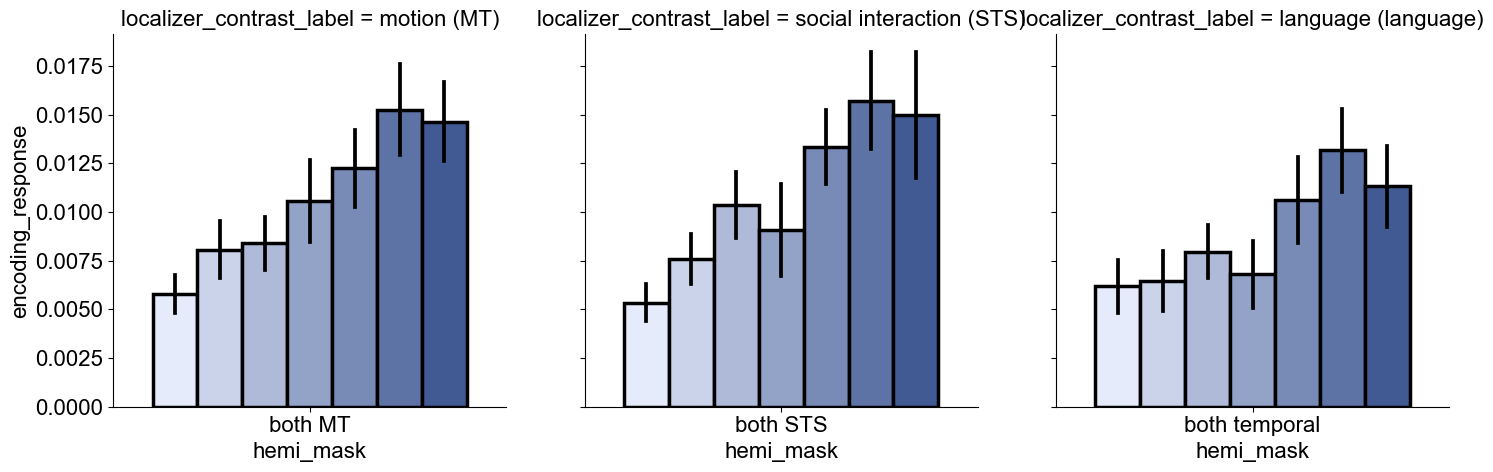

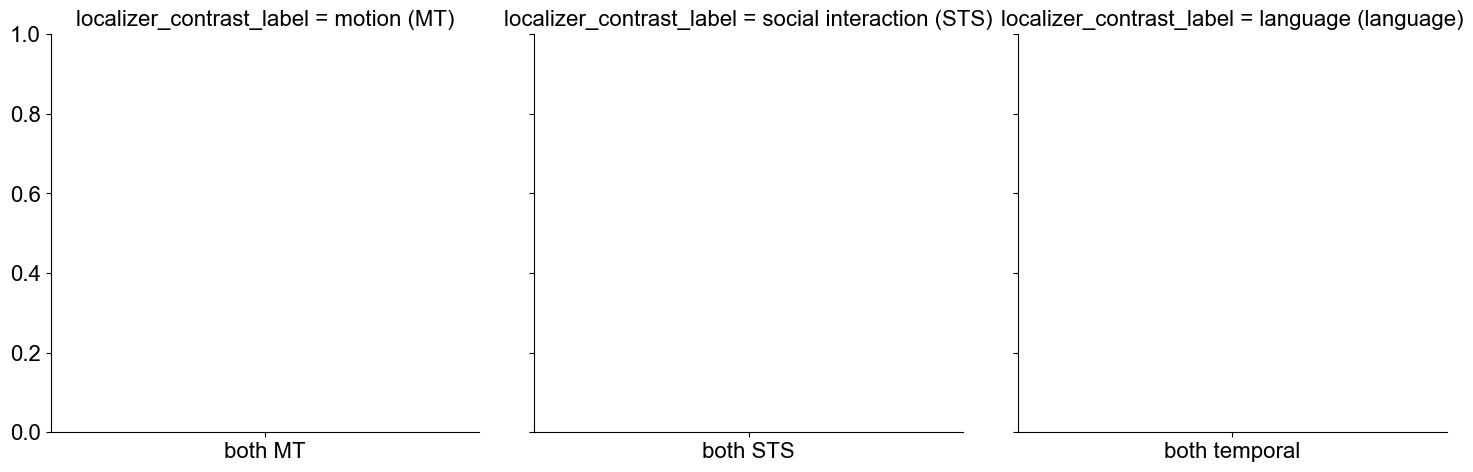

In [21]:
load = True ## load precomputed results while plotting
secondlevel_ind = get_secondlevel_individual(base_dir,'joint')
features = secondlevel_ind.feature_names
glm_localizers_to_plot = ['motion','social interaction', 'language'] 
glm_localizer_label_dict = {'motion':'MT','social interaction':'STS','language':'language','DMN':'STS'}

#average over all layers of any relevant DNNs (collapse all layers down to one feature name)
features_no_layer = [feature if 'layer' not in feature else feature.split('_')[0] for feature in features]
features = list(dict.fromkeys(features_no_layer)) #get rid of duplicates
secondlevel_ind.feature_names = features
secondlevel_ind.plot_features = features
secondlevel_ind.scale_by = '' #not scaling the results by anything (could scale by total variance explained with 'total_variance')
response_label = 'ind_product_measure' #extracting the product measure of each feature
average_posterior_anterior = True #average pSTS and aSTS (social interaction region) together, pTemp and aTemp (language regions) together

perc_top_voxels = args_dict['perc_top_voxels']
if generate_subfigures:
    filepath_tag = ''
    figure_tag='all'

    ### the main variance decomposition results ###
    ## glm_voxel selection plots multiple subfigures: 
    ## - the stacked bar plot of the variance explained by each feature in the joint model for each localized region (from encoding model)
    ## - the responses to each condition of the localizer experiment in each localized region (from glm)
    csv_path,pkl_path = secondlevel_ind.glm_voxel_selection(load=load,legend_below=True,label_region=True,restrict_legend=True,average_posterior_anterior=average_posterior_anterior,stats_to_do='compare_to_zero',plot_stacked=True,plot_ind=True,response_label=response_label,localizers_to_plot=glm_localizers_to_plot,localizer_label_dict=glm_localizer_label_dict,filepath_tag=filepath_tag,figure_tag=figure_tag)
    
    ### supplemental results plotting the voxelwise variance decomposition of AlexNet and sBERT in each region (all subjects) ###
    region_names = ['MT','pSTS','aSTS','pTemp','aTemp','frontal']
    feature_names = ['alexnet','sbert']
    feature_sources = {}
    for feature in feature_names:
        feature_sources[feature] = 'enc_voxelwise'
    feature_sources[('interact','no_interact')] = 'glm_voxelwise'
    feature_sources[('intact','degraded')] = 'glm_voxelwise'
    save_dir = secondlevel_ind.figure_dir + '/spatial_correlation/'+filepath_tag+'_'
    plotting_helpers.plot_voxelwise_feature_scatter(pkl_path=pkl_path,region_names=region_names,
                                        feature_names=feature_names,
                                        feature_sources=feature_sources,
                                        save_dir=save_dir,plot_scatter=True)

    ### supplemental results plotting the product measure of AlexNet vs the combined product measures of the language models (hubert, word2vec, and sbert) ###
    filepath_tag='AlexNet_vs_language'
    figure_tag=''
    secondlevel_ind.plot_features = ['alexnet','language']
    secondlevel_ind.feature_names = ['alexnet','language']
    average_posterior_anterior=False
    secondlevel_ind.glm_voxel_selection(load=load,label_region=False,restrict_legend=True,average_posterior_anterior=average_posterior_anterior,stats_to_do='compare_features',plot_stacked=False,plot_ind=True,response_label=response_label,localizers_to_plot=glm_localizers_to_plot,localizer_label_dict=glm_localizer_label_dict,filepath_tag=filepath_tag,figure_tag=figure_tag)

    ### supplemental results plotting the cross subject encoding in each localized region ###
    filepath_tag = '_for_cross_subject'
    response_label = 'performance'
    secondlevel_ind.glm_voxel_selection(load=load,average_posterior_anterior=average_posterior_anterior,stats_to_do=None,plot_stacked=False,plot_ind=True,response_label=response_label,localizers_to_plot=glm_localizers_to_plot,localizer_label_dict=glm_localizer_label_dict,filepath_tag=filepath_tag,figure_tag=figure_tag)

    secondlevel_ind.models = ['cross-subject encoding (MT+STS+language)','cross-subject encoding (ISC)']
    # NOTE:load needs to be True here (the relevant analyses have already been run above, just plotting the different models now)
    secondlevel_ind.glm_voxel_selection(load=True,plot_lines=False,average_posterior_anterior=average_posterior_anterior,stats_to_do=None,plot_stacked=False,plot_ind=True,response_label=response_label,localizers_to_plot=glm_localizers_to_plot,localizer_label_dict=glm_localizer_label_dict,filepath_tag=filepath_tag,figure_tag=figure_tag)
    
    ### supplemental results of an encoding model using more advanced vision and language models ###
    secondlevel_ind = get_secondlevel_individual(base_dir,'vislang_transformers')
    features = ['SimCLR','language_transformers']
    secondlevel_ind.feature_names = features
    secondlevel_ind.plot_features = features
    filepath_tag = 'SimCLR_lang_compiled'
    response_label = 'ind_product_measure'
    secondlevel_ind.glm_voxel_selection(load=load,label_region=False,plot_lines=False,average_posterior_anterior=average_posterior_anterior,stats_to_do=None,plot_stacked=False,plot_ind=True,response_label=response_label,localizers_to_plot=glm_localizers_to_plot,localizer_label_dict=glm_localizer_label_dict,filepath_tag=filepath_tag,figure_tag=figure_tag)

    ### results separately plotting the product measure of each layer in alexnet ###
    secondlevel_ind = get_secondlevel_individual(base_dir,'vislang')
    filepath_tag='alexnet_layers'
    figure_tag='alexnet_layers'
    secondlevel_ind.plot_features = ['alexnet_layer'+str(layer) for layer in [1,2,3,4,5,6,7]]
    secondlevel_ind.glm_voxel_selection(load=load,restrict_legend=True,average_posterior_anterior=average_posterior_anterior,stats_to_do=None,plot_stacked=False,plot_ind=True,response_label=response_label,localizers_to_plot=glm_localizers_to_plot,localizer_label_dict=glm_localizer_label_dict,filepath_tag=filepath_tag,figure_tag=figure_tag)
    figure_tag='alexnet_layers_hemis_averaged'
    secondlevel_ind.glm_voxel_selection(load=load,restrict_legend=True,average_left_right=True,average_posterior_anterior=average_posterior_anterior,stats_to_do=None,plot_stacked=False,plot_ind=True,response_label=response_label,localizers_to_plot=glm_localizers_to_plot,localizer_label_dict=glm_localizer_label_dict,filepath_tag=filepath_tag,figure_tag=figure_tag)


### Preference brain maps

In [8]:
## NOTE: The ROI files that are overlaid on the preference maps are generated during the joint model variance decomposition analyses, so that needs to have run first!

if generate_subfigures:
    # generate combined mask glm binary masks
    secondlevel_ind.generate_binary_localizer_maps_glm(plot=True,glm_task='SIpointlights')
    secondlevel_ind.generate_binary_localizer_maps_glm(plot=True,glm_task='language')

    # preference map plotting
    plotting = ['preference_map']
    secondlevel_ind = get_secondlevel_individual(base_dir,'joint')
    features = secondlevel_ind.feature_names
    features_no_layer = [feature if 'layer' not in feature else feature.split('_')[0] for feature in features] 
    features = features_no_layer

    file_tag = 'all' #including all features when computing the preference map (for DNN's all layers are added together)
    # NOTE: there will be some errors here because not all subjects completed the language localizer (which is overlaid on the preference map)
    # this is fine, a preference map will still be generated but with only the social interaction regions overlaid
    secondlevel_ind.generate_preference_maps(measure='ind_product_measure',views=['lateral','medial','ventral'],restricted=True,threshold=0.0001,features=features,file_tag=file_tag)

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/secondlevel_individual_encoding.py:267: RuntimeWarning: All-NaN slice encountered
  nan_col = np.nanmax(temp_transposed, axis=1)


No such file or no access: '../analysis/SecondLevelIndividual/localizer_masks/sub-05_smoothingfwhm-3.0_mask-pTemp_aTemp_glm_loc-intact-degraded_run-all_binary.nii.gz'
No such file or no access: '../analysis/SecondLevelIndividual/localizer_masks/sub-06_smoothingfwhm-3.0_mask-pTemp_aTemp_glm_loc-intact-degraded_run-all_binary.nii.gz'
No such file or no access: '../analysis/SecondLevelIndividual/localizer_masks/sub-07_smoothingfwhm-3.0_mask-pTemp_aTemp_glm_loc-intact-degraded_run-all_binary.nii.gz'
No such file or no access: '../analysis/SecondLevelIndividual/localizer_masks/sub-08_smoothingfwhm-3.0_mask-pTemp_aTemp_glm_loc-intact-degraded_run-all_binary.nii.gz'
No such file or no access: '../analysis/SecondLevelIndividual/localizer_masks/sub-09_smoothingfwhm-3.0_mask-pTemp_aTemp_glm_loc-intact-degraded_run-all_binary.nii.gz'
No such file or no access: '../analysis/SecondLevelIndividual/localizer_masks/sub-10_smoothingfwhm-3.0_mask-pTemp_aTemp_glm_loc-intact-degraded_run-all_binary.nii.gz

### AlexNet analyses
NOTE: to run these from scratch, please download the 

In [ ]:
### computing the response similarity (correlation between the fitted encoding model weights of AlexNet layer 6) between different localized regions
load = load
secondlevel_ind = get_secondlevel_individual(base_dir,'vislang')
features = {'alexnet': ['alexnet_layer6'] }
filepath_tag = 'layer6'
if generate_subfigures:
    secondlevel_ind.compute_response_similarity(load=load,response='weights',average_posterior_anterior=True,split_hemi=True,axes=features,filepath_tag=filepath_tag)
    
    #version that averages across hemisphere
    filepath_tag = 'layer6_hemis_averaged'
    secondlevel_ind.compute_response_similarity(load=load,response='weights',average_posterior_anterior=True,split_hemi=False,axes=features,filepath_tag=filepath_tag)

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/plotting_helpers.py:1541: RuntimeWarning: Mean of empty slice
  value = np.nanmean(combined['corr'])
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/src/plotting_helpers.py:1541: RuntimeWarning: Mean of empty slice
  value = np.nanmean(combined['corr'])


Linear mixed model fit by REML [’lmerMod’]
Formula: corr~super_pair+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 218	 Groups: {'subject': 34.0}

Log-likelihood: 19.976 	 AIC: -29.952

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.022  0.150
Residual               0.036  0.191

No random effect correlations specified

Fixed effects:

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: corr~super_pair+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 218	 Groups: {'subject': 34.0}

Log-likelihood: 25.908 	 AIC: -41.816

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.013  0.116
Residual 

In [14]:
### interpreting the highest weighted beta units from AlexNet layer 6 
load = False
## computing the correlation between each of the top 2.5% highest weighted units and each of the annotated features of the movie
if not load:
    secondlevel_ind = get_secondlevel_individual(base_dir,'vislang')
    secondlevel_ind.highest_beta_weights_correlate_with_annotated_features_multi(feature_name='alexnet_layer6', mask_names=['MT','STS','temporal','frontal'], top_percent=2.5)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed: 11.6min
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed: 49.0min
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_d

Running ANOVA for both hemisphere per region pair
  Testing pair: both MT vs both STS
Linear mixed model fit by REML [’lmerMod’]
Formula: encoding_response~1+Feature_Space+hemi_mask+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 952	 Groups: {'subject': 34.0}

Log-likelihood: 1354.929 	 AIC: -2675.858

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.000  0.010
Residual               0.003  0.054

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: encoding_response~1+Feature_Space*hemi_mask+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 952	 Groups: {'subject': 34.0}

Log-likelihood: 1349.183 	 AIC: -2638.367

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.000  0.010
Residual               0.003  0.053

No random effect correlations specified

Fixed effects:

  Testing pair: both MT vs both temporal
Linear mi

/Users/hsmall2/anaconda3/envs/ubiquitous-vis/lib/python3.9/site-packages/statsmodels/stats/multitest.py:151: RuntimeWarning: invalid value encountered in multiply
  pvals_corrected = pvals * float(ntests)


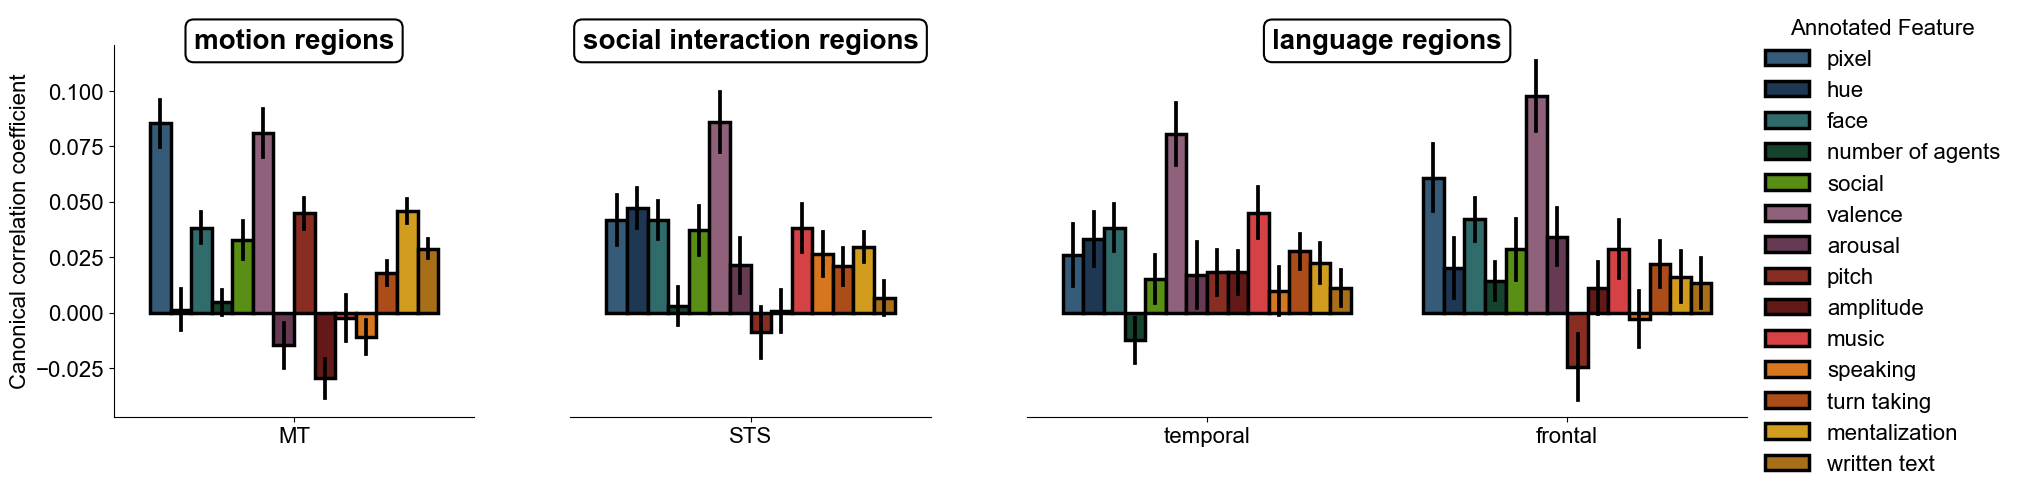

In [19]:
### measuring the similarity between the highest weighted units of AlexNet layer 6 and annotated features
# by copmuting the CCA between top 25 units and each annotated feature
layer = 'alexnet_layer6'
secondlevel_ind = get_secondlevel_individual(base_dir,'vislang')
load=True
results_path = os.path.join(args_dict['out_dir'],'SecondLevelIndividual')
if generate_subfigures:
    results_df = secondlevel_ind.compare_units_to_features(load=load, unit_csv_path = results_path, model='vislang', layer_name=layer, method='cca', top_n = 25, split_hemi=False)

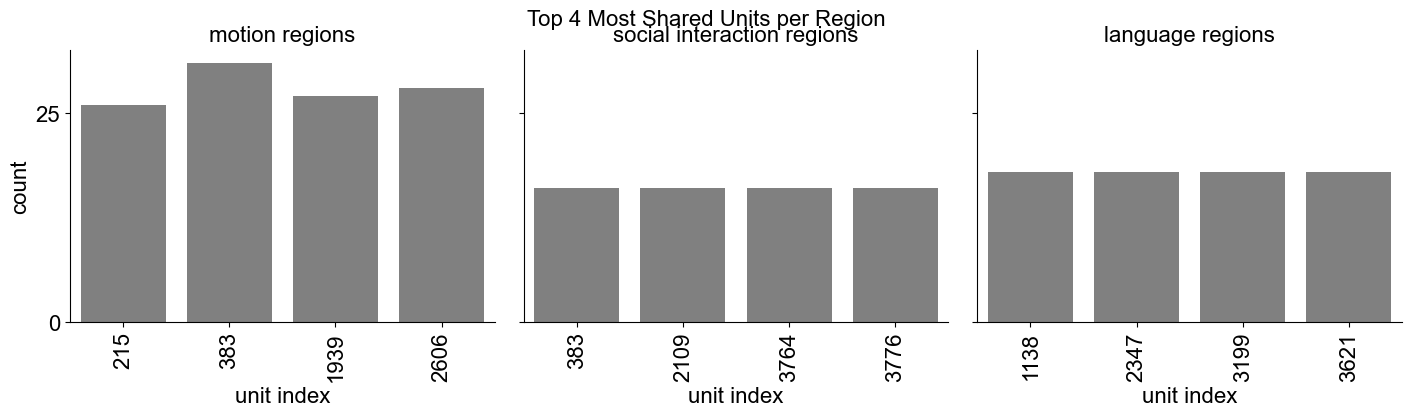

In [20]:
### interpreting some example single units
secondlevel_ind = get_secondlevel_individual(base_dir,'vislang')
layer = 'alexnet_layer6'
results_path = os.path.join(args_dict['out_dir'],'SecondLevelIndividual','top_unit_correlations')
plot_units = {'motion regions':[383], 'social interaction regions':[3764], 'language regions':[1138], 'temporal':[2347], 'frontal':[1138]}

# selecting the top 4 most frequent units (occur in the top 2.5% units in the most subjects)
# generates a plot of the most frequent units per region
unit_df, unit_list = secondlevel_ind.select_most_frequent_units_per_region(results_path, model='vislang', layer = layer, top_n=4,split_by_hemi=False,split_posterior_anterior=False,plot_points=False)

# selecting some specific units (from equally most frequent units)
# we also select the unit that is most frequent in temporal and frontal language regions
unit_list['motion regions'] = [383]
unit_list['social interaction regions'] = [3764]
unit_list['language regions'] = [1138]

if generate_subfigures:
    # run again, but this time plot the specific units correlations with all of the annotated features
    # plot_units = {'motion regions':[383], 'social interaction regions':[3764], 'language regions':[1138], 'temporal':[2347], 'frontal':[1138]}
    # unit_df, unit_list = secondlevel_ind.select_most_frequent_units_per_region(results_path, model='vislang', layer = layer, top_n=4,split_by_hemi=False,split_posterior_anterior=False,plot_points=False,plot_units=plot_units)

    ## plotting the time series of each unit and the windows of maximum correlation for some specific annotated features
    # showing how a unit can be correlated with multiple different annotated features at different parts of the movie
    # and that the top units in each region are responding to different features of the movie
    window_size = 40
    for unit in unit_list['motion regions']:
        secondlevel_ind.plot_unit_feature_highlights(
                layer=layer,
                unit=unit,
                annotated_features=['pixel','valence','face','social','written_text','num_agents'],
                image_dir="../features/frames",
                window_size=window_size,
                title = '',
                top_k=1,
                output_path=f"../figures/subfigures/SecondLevelIndividual/unit_interpretations/" 
                )
    for unit in unit_list['social interaction regions']:
        secondlevel_ind.plot_unit_feature_highlights(
                layer=layer,
                unit=unit,
                annotated_features=['pixel','valence','face','social','written_text','num_agents'],
                image_dir="../features/frames",
                window_size=window_size,
                title = '',
                y_min=-20,
                top_k=1,
                output_path=f"../figures/subfigures/SecondLevelIndividual/unit_interpretations/" 
                )
    for unit in unit_list['language regions']:
        secondlevel_ind.plot_unit_feature_highlights(
                layer=layer,
                unit=unit,
                annotated_features=['pixel','valence','face','social','written_text','num_agents'],
                image_dir="../features/frames",
                window_size=window_size,
                title = '',
                top_k=1,
                output_path=f"../figures/subfigures/SecondLevelIndividual/unit_interpretations/" 
                )